In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import jams
import tensorly as tl
import librosa
import librosa.display as dp

import musicntd.data_manipulation as dm
import musicntd.tensor_factory as tf
import musicntd.autosimilarity_segmentation as as_seg
from musicntd.model.current_plot import *
import musicntd.scripts.overall_scripts as scr
import nn_fac.ntd as NTD

In [2]:
# Song
persisted_path = "C:\\Users\\amarmore\\Desktop\\data_persisted"

sampling_rate = 44100 # Obligatoire, sinon l'estimation des mesures ne fonctionne pas.
hop_length = 32
hop_length_seconds = hop_length/sampling_rate
subdivision = 96

# Come Together
song_path = "C:\\Users\\amarmore\\Downloads\\The Beatles - Come Together.wav"
annotation_path = "C:\\Users\\amarmore\\Downloads\\annotations\\ComeTogether.lab"

# RWC Pop
#dataset_path = "C:\\Users\\amarmore\\Desktop\\Audio samples\\RWC Pop\\Entire RWC"
#annotations_type = "MIREX10"
#annotations_folder = "C:\\Users\\amarmore\\Desktop\\Audio samples\\RWC Pop\\annotations\\{}".format(annotations_type)
#song_number = 1
#song_path = dataset_path + "\\" + str(song_number) + ".wav"
#annotation_path = annotations_folder + dm.get_annotation_name_from_song(song_number, annotations_type)

song_name = song_path.split("\\")[-1].replace(".wav","")

the_signal, original_sampling_rate = sf.read(song_path)
if original_sampling_rate != sampling_rate:
    the_signal = librosa.core.resample(np.asfortranarray(the_signal), original_sampling_rate, sampling_rate)

# Annotations - Homemade
annotations = dm.get_segmentation_from_txt(annotation_path, "MIREX10")
references_segments = np.array(annotations)[:,0:2]

# Get the downbeats
bars = scr.load_or_save_bars(persisted_path, song_path)

# Annotaions in bars
annotations_frontiers_barwise = dm.frontiers_from_time_to_bar(references_segments[:,1], bars)
annotations_segments_barwise = dm.frontiers_to_segments(annotations_frontiers_barwise)

spectrogram = scr.load_or_save_spectrogram(persisted_path, song_path, "pcp", hop_length, fmin = 98)

tensor_spectrogram = tf.tensorize_barwise(spectrogram, bars, hop_length_seconds, subdivision)

In [3]:
indexes = [2,4,5,6,8]
S = [annotations_segments_barwise[i] for i in indexes]
T = [(int((annotations_segments_barwise[i][0] + annotations_segments_barwise[i+1][0])/2),int((annotations_segments_barwise[i][1] + annotations_segments_barwise[i+1][1])/2)) for i in indexes]

In [4]:
ranks = [12,12,10]
core, factors = scr.NTD_decomp_as_script(persisted_path, "_{}_{}_{}_{}".format(song_name, "pcp", "chromas", subdivision), tensor_spectrogram, ranks, init = "chromas")

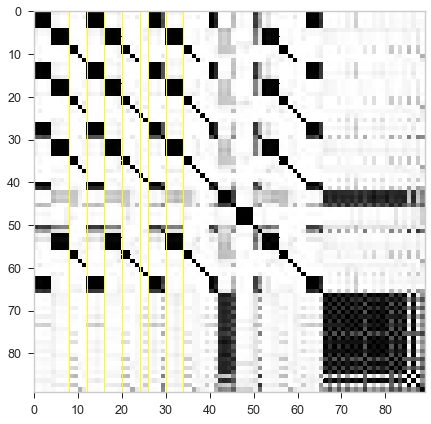

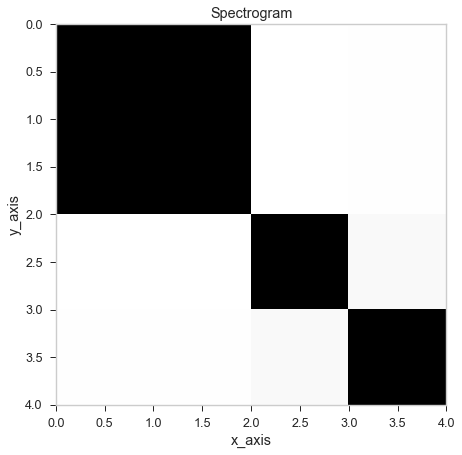

In [5]:
bar_autosimilarity = as_seg.get_autosimilarity(factors[2], transpose = True, normalize = True)
plot_spec_with_annotations(bar_autosimilarity, S)
plot_me_this_spectrogram(bar_autosimilarity[S[0][0]:S[0][1],S[0][0]:S[0][1]])

In [6]:
kernels = as_seg.compute_all_kernels(10)
good_conv = []
bad_conv = []

for good_segment in S:
    good_conv.append(as_seg.convolutionnal_cost(bar_autosimilarity[good_segment[0]:good_segment[1],good_segment[0]:good_segment[1]], kernels))
for bad_segment in T:
    bad_conv.append(as_seg.convolutionnal_cost(bar_autosimilarity[bad_segment[0]:bad_segment[1],bad_segment[0]:bad_segment[1]], kernels))


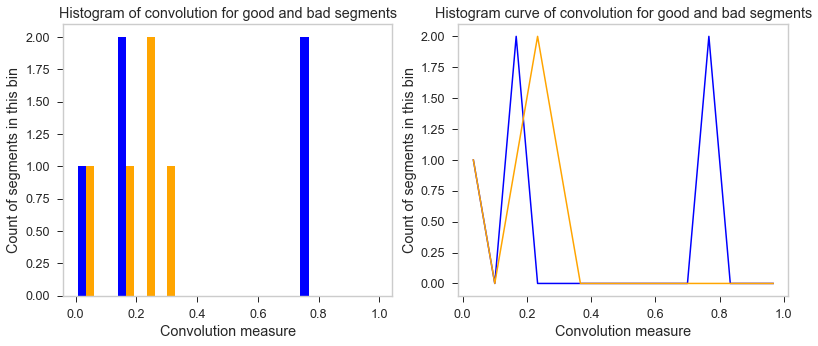

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Convolution measure")
axs[0].set_ylabel("Count of segments in this bin")
n, bins, patches = axs[0].hist([good_conv, bad_conv], range = (0, 1), bins = 15, color = ['blue', 'orange'])
axs[0].set_title("Histogram of convolution for good and bad segments")
axs[1].set_xlabel("Convolution measure")
axs[1].set_ylabel("Count of segments in this bin")
axs[1].plot([(bins[i] + bins[i+1])/2 for i in range(len(bins) - 1)], n[0], color = 'blue')
axs[1].plot([(bins[i] + bins[i+1])/2 for i in range(len(bins) - 1)], n[1], color = 'orange')
axs[1].set_title("Histogram curve of convolution for good and bad segments")
plt.show()

# Script, on all dataset

In [8]:
persisted_path = "C:\\Users\\amarmore\\Desktop\\data_persisted"
folder = "C:\\Users\\amarmore\\Desktop\\Audio samples\\RWC Pop\\Entire RWC"

annotations_type = "MIREX10"
annotations_folder = "C:\\Users\\amarmore\\Desktop\\Audio samples\\RWC Pop\\annotations\\{}".format(annotations_type)
paths = scr.load_RWC_dataset(folder, annotations_type)

## Generating good and bad segments

In [9]:
#indexes = [2,4,5,6,8]

np.random.seed(42)

good_segments_all_songs = []
bad_segments_all_songs = []

number_of_segments = 5

for song_and_annotations in paths:
    song_name = song_and_annotations[0].replace(".wav","")
    annot_path = "{}\\{}".format(annotations_folder, song_and_annotations[1])
    annotations = dm.get_segmentation_from_txt(annot_path, annotations_type)
    references_segments = np.array(annotations)[:, 0:2]

    bars, spectrogram = scr.load_or_save_spectrogram_and_bars(persisted_path, "{}\\{}".format(folder, song_name), "pcp", hop_length)

    annotations_frontiers_barwise = dm.frontiers_from_time_to_bar(references_segments[:,1], bars)
    annotations_segments_barwise = dm.frontiers_to_segments(annotations_frontiers_barwise)
    indexes = np.random.randint(1, high=len(annotations_segments_barwise) - 1, size = number_of_segments)
    while min([annotations_segments_barwise[i][1] - annotations_segments_barwise[i][0] for i in indexes]) <= 1 or len(np.unique(indexes)) != len(indexes):
        indexes = np.random.randint(1, high=len(annotations_segments_barwise) - 1, size = number_of_segments)
    print(indexes)

    good_segments_all_songs.append([annotations_segments_barwise[i] for i in indexes])

    #T = [(int((annotations_segments_barwise[i][0] + annotations_segments_barwise[i+1][0])/2),int((annotations_segments_barwise[i][1] + annotations_segments_barwise[i+1][1])/2)) for i in indexes]
    T = []
    for i in indexes:
        seg_size = annotations_segments_barwise[i][1] - annotations_segments_barwise[i][0]
        lag = np.random.randint(1, high=seg_size)
        if annotations_segments_barwise[i][1] + lag >= annotations_segments_barwise[-1][1]:
            T.append((annotations_segments_barwise[i][0] - lag,annotations_segments_barwise[i][1] - lag))
        else:
            T.append((annotations_segments_barwise[i][0] + lag,annotations_segments_barwise[i][1] + lag))
    bad_segments_all_songs.append(T)

[14 17  4 18  8]
[10  4  6 13  2]
[ 8  5 13  2 15]
[ 1 11  5 10  7]
[ 3  1  5 10  7]
[ 3  6 12  2 10]
[9 3 7 6 8]
[2 5 6 7 4]
[6 8 5 4 2]
[ 1  9 11  6  3]
[9 1 8 7 2]
[17  2  1 16 12]
[6 8 4 3 9]
[ 1 14  5 16  4]
[13 19  8  2  1]
[ 5 12 13 16  3]
[ 6  3 12  9  5]
[ 3 12  1  4 15]
[11  6  7 13 10]
[ 6 15 11  5  1]
[ 7  4  6 13 20]
[13  2 12 10 14]
[9 8 5 1 7]
[3 1 8 5 4]
[4 8 2 3 1]
[14  2 18  3 17]
[14  2  3  9  7]
[11 13  8  4  9]
[5 9 8 3 1]
[ 5 12  1  7 13]
[ 7 14 15 16  5]
[ 7 14 10  5  3]
[12  1 13  6  7]
[ 8 16 13  1 17]
[ 3 12  6  7 11]
[10  4 12  8 13]
[5 4 6 1 7]
[15 16 11  5  4]
[ 1  3 16 11 12]
[ 4 16 11  6 15]
[ 6  5 15  2 10]
[11 17 13  1  2]
[10 19 17 14  9]
[ 5 11  9  1  7]
[ 6  1  5  9 12]
[16 17  4  1  8]
[ 8  6 14 10 12]
[ 7  3 15 14 11]
[15  5 10  7 17]
[17 13  4 10  3]
[12  3 10  9  5]
[11  9  3 19  8]
[ 9  2 11  8 10]
[10  6  5 11  4]
[ 2  8 10  5  7]
[2 6 5 8 3]
[ 1  8  6 12 13]
[ 3  8 10  4  1]
[ 6  9  1 13  5]
[5 4 3 6 2]
[14 11 12 10 13]
[10  9  6  3 13]
[2 1 3

In [10]:
good_segments_all_songs

[[(84, 92), (100, 106), (21, 29), (106, 114), (45, 48)],
 [(70, 78), (26, 34), (42, 50), (94, 102), (14, 18)],
 [(39, 43), (21, 29), (69, 77), (5, 13), (87, 95)],
 [(1, 5), (73, 81), (29, 37), (65, 73), (45, 53)],
 [(25, 33), (8, 17), (41, 49), (82, 90), (58, 66)],
 [(18, 22), (34, 43), (76, 84), (9, 18), (63, 68)],
 [(70, 78), (17, 26), (52, 62), (44, 52), (62, 70)],
 [(18, 26), (43, 53), (53, 61), (61, 70), (35, 43)],
 [(48, 52), (60, 69), (40, 48), (31, 40), (14, 23)],
 [(8, 16), (71, 75), (83, 93), (44, 52), (24, 32)],
 [(67, 77), (1, 9), (59, 67), (51, 59), (9, 17)],
 [(139, 147), (17, 25), (8, 17), (131, 139), (99, 107)],
 [(47, 51), (55, 67), (32, 39), (24, 32), (67, 75)],
 [(4, 12), (111, 119), (37, 45), (127, 135), (28, 37)],
 [(71, 78), (106, 108), (42, 50), (16, 21), (8, 16)],
 [(34, 38), (76, 85), (85, 93), (105, 113), (18, 26)],
 [(43, 51), (19, 27), (87, 95), (67, 71), (35, 43)],
 [(15, 23), (91, 99), (1, 11), (23, 33), (113, 121)],
 [(84, 92), (44, 52), (52, 60), (100, 1

In [11]:
bad_segments_all_songs

[[(88, 96), (102, 108), (27, 35), (100, 108), (47, 50)],
 [(72, 80), (30, 38), (44, 52), (96, 104), (16, 20)],
 [(40, 44), (23, 31), (70, 78), (9, 17), (83, 91)],
 [(3, 7), (74, 82), (33, 41), (72, 80), (46, 54)],
 [(32, 40), (14, 23), (48, 56), (85, 93), (59, 67)],
 [(19, 23), (40, 49), (77, 85), (14, 23), (65, 70)],
 [(73, 81), (18, 27), (57, 67), (45, 53), (65, 73)],
 [(25, 33), (51, 61), (56, 64), (62, 71), (42, 50)],
 [(50, 54), (66, 75), (43, 51), (38, 47), (22, 31)],
 [(12, 20), (74, 78), (79, 89), (47, 55), (26, 34)],
 [(75, 85), (2, 10), (62, 70), (55, 63), (10, 18)],
 [(144, 152), (22, 30), (16, 25), (134, 142), (106, 114)],
 [(50, 54), (64, 76), (37, 44), (26, 34), (73, 81)],
 [(11, 19), (114, 122), (38, 46), (128, 136), (36, 45)],
 [(75, 82), (107, 109), (49, 57), (20, 25), (9, 17)],
 [(37, 41), (84, 93), (86, 94), (106, 114), (22, 30)],
 [(48, 56), (20, 28), (93, 101), (68, 72), (42, 50)],
 [(20, 28), (96, 104), (8, 18), (24, 34), (116, 124)],
 [(91, 99), (46, 54), (55, 63

# Convolution cost on good/bad segments

### Note: convolution is here normalized by the 8-size convolution.

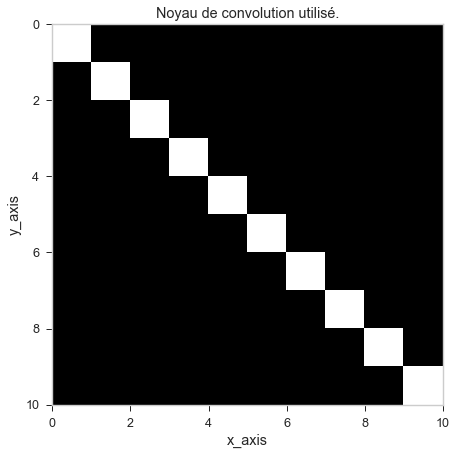

RANKS: 12, 16, 16


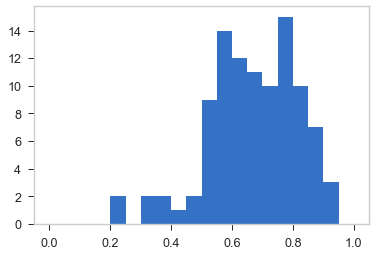

F mesure moyenne: 0.668349921848488


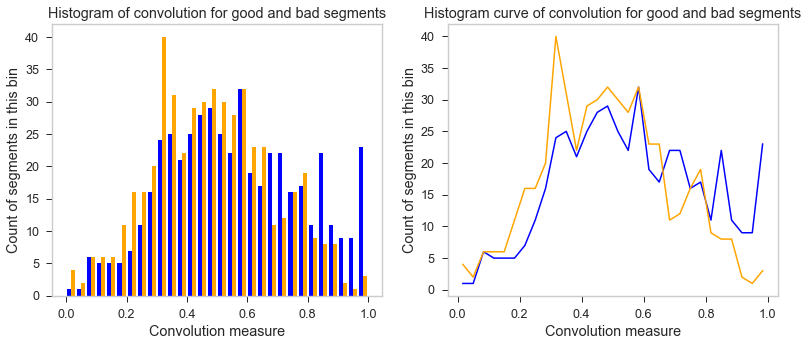

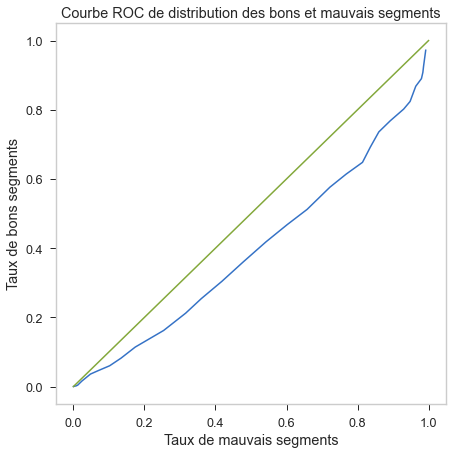

RANKS: 12, 16, 24


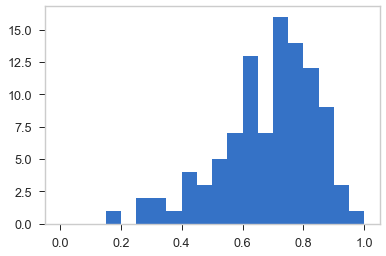

F mesure moyenne: 0.6854477100314349


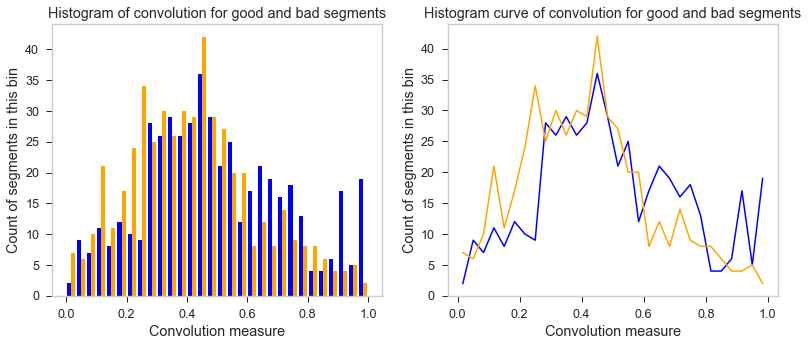

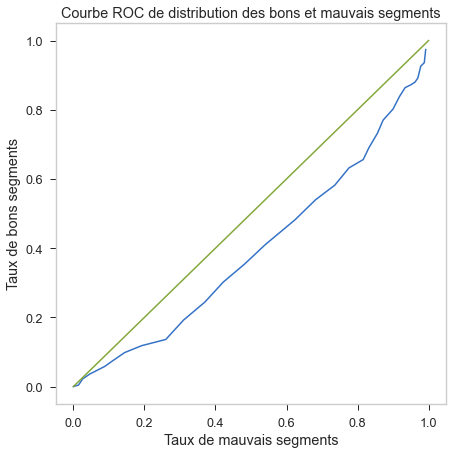

RANKS: 12, 16, 32


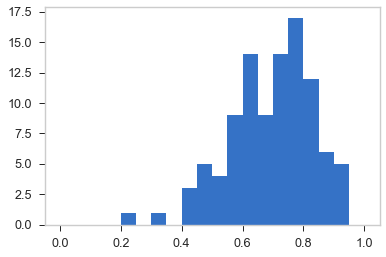

F mesure moyenne: 0.6966755755807063


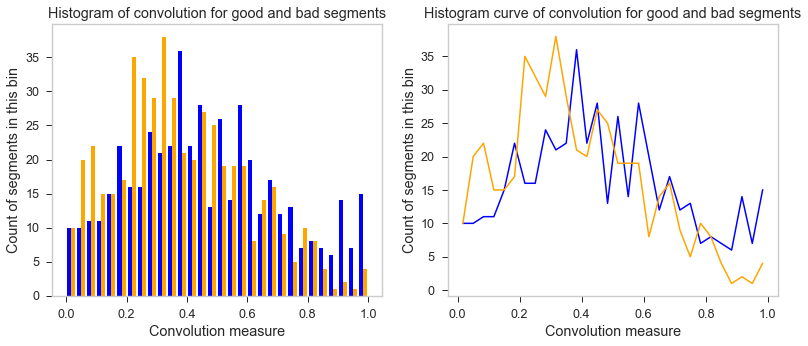

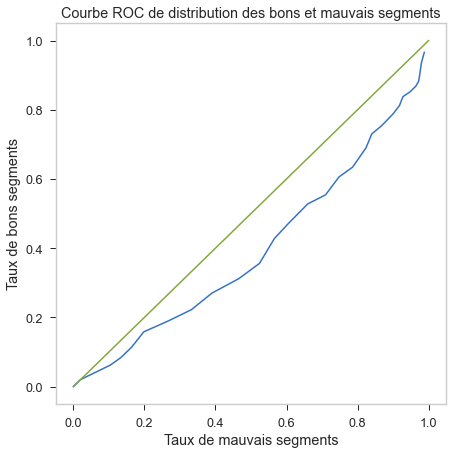

RANKS: 12, 24, 16


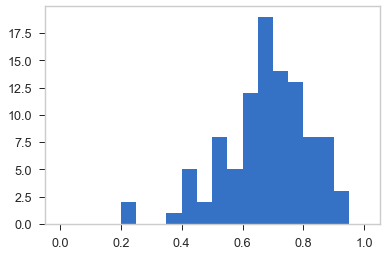

F mesure moyenne: 0.6791669237962868


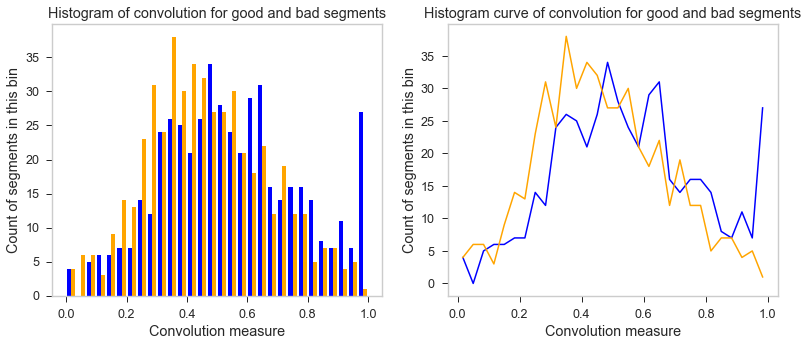

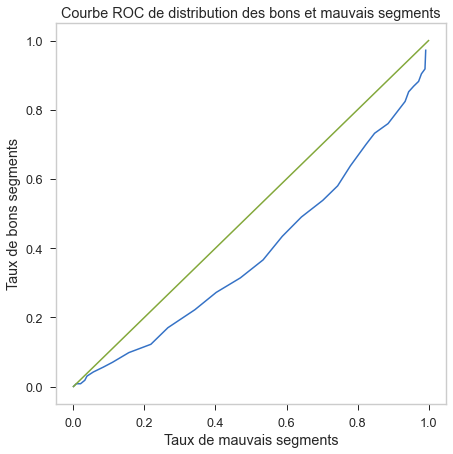

RANKS: 12, 24, 24


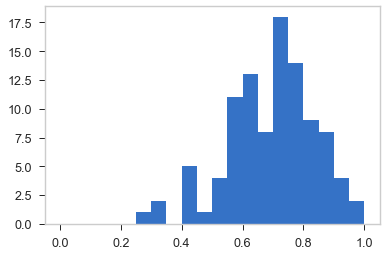

F mesure moyenne: 0.6962686540608353


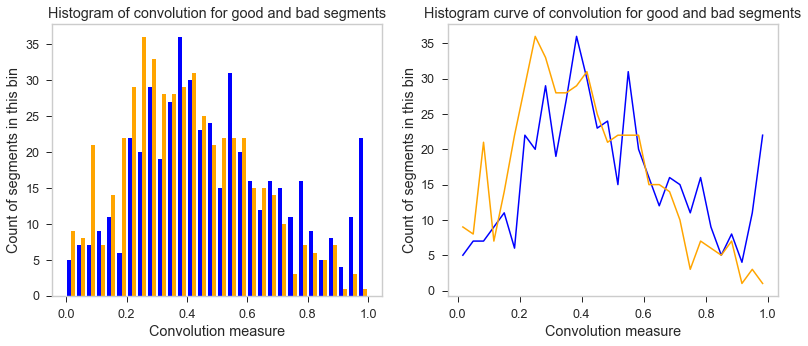

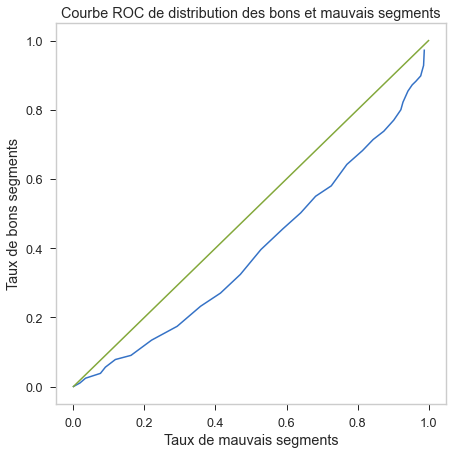

RANKS: 12, 24, 32


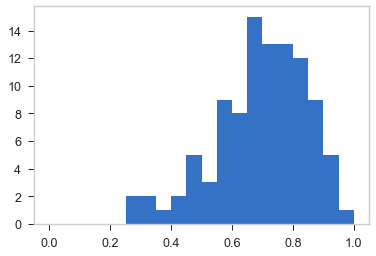

F mesure moyenne: 0.6962591491784563


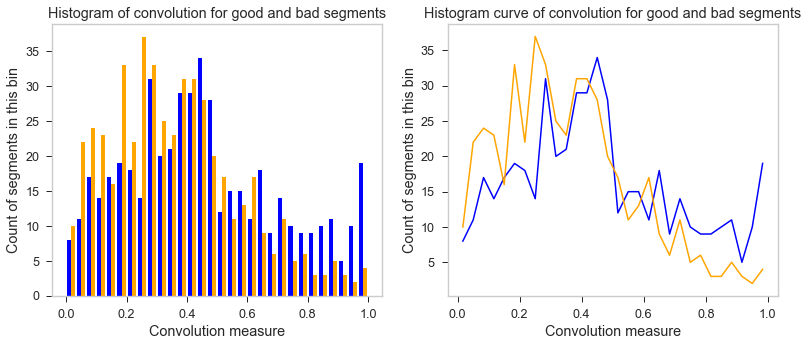

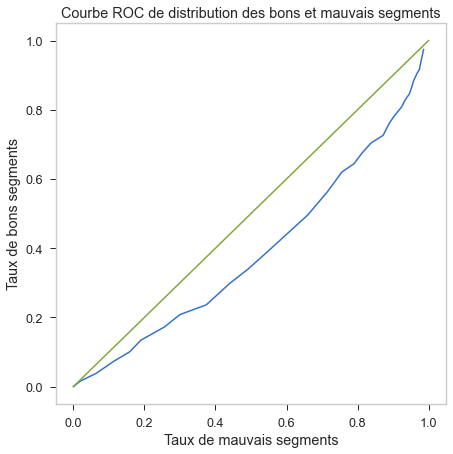

RANKS: 12, 32, 16


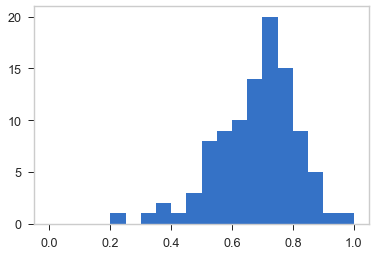

F mesure moyenne: 0.6785391382359544


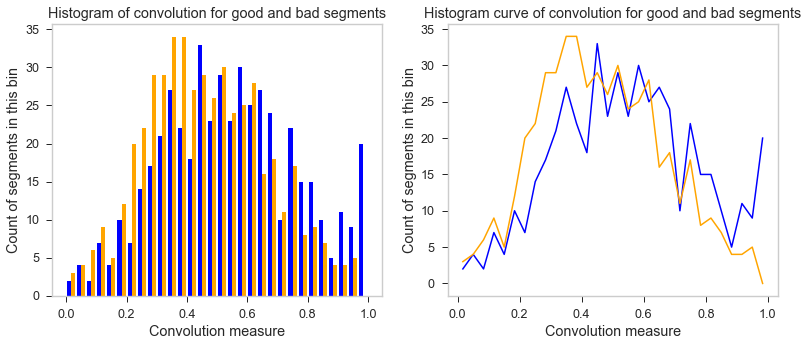

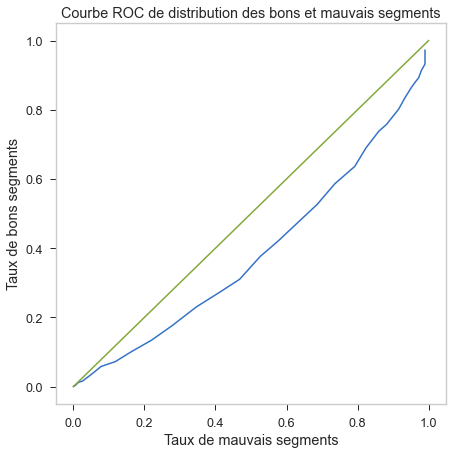

RANKS: 12, 32, 24


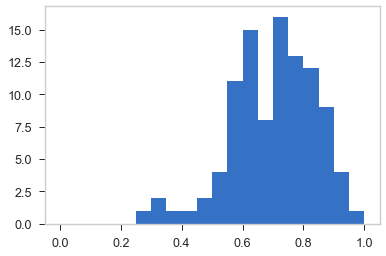

F mesure moyenne: 0.7017779799472795


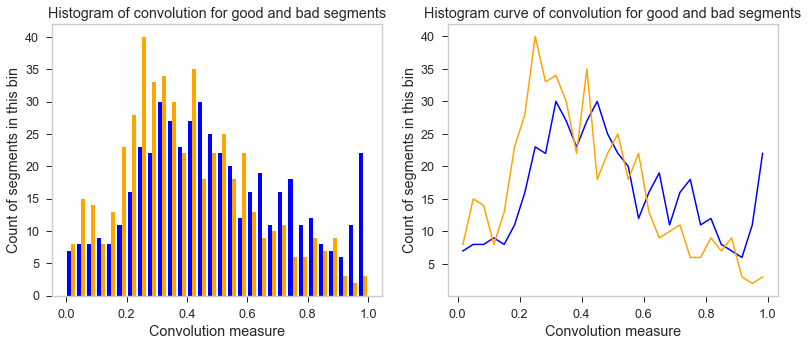

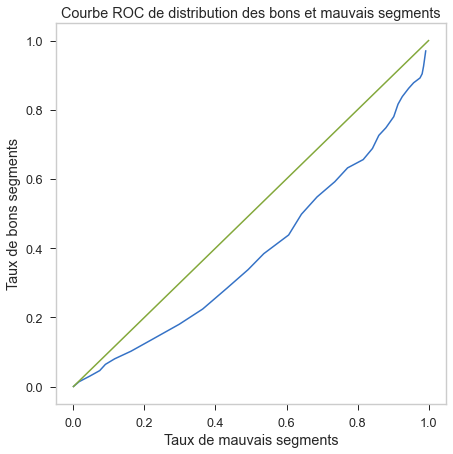

RANKS: 12, 32, 32


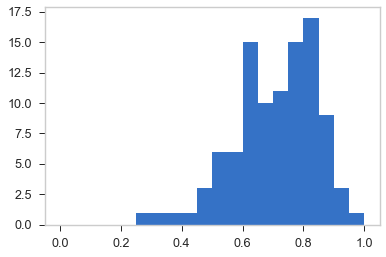

F mesure moyenne: 0.7067069622979583


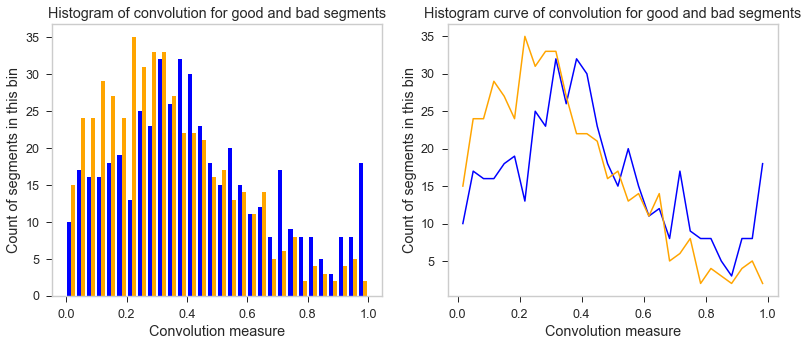

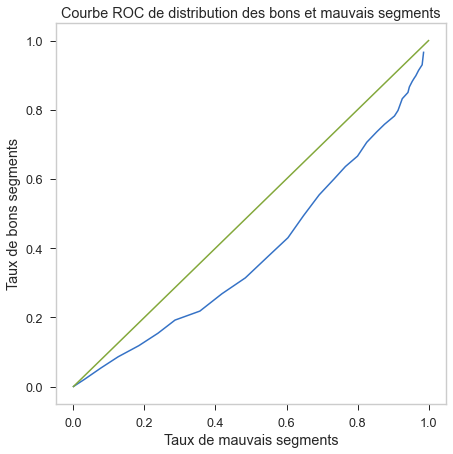

In [12]:
#ranks = [12,32,32]
sampling_rate = 44100 # Obligatoire, sinon l'estimation des mesures ne fonctionne pas.
subdivision = 96
hop_length = 32
hop_length_seconds = hop_length/sampling_rate

kernels = as_seg.compute_all_kernels(32)
plot_me_this_spectrogram(kernels[10], title = "Noyau de convolution utilisé.")
ranks_of_h = [16,24,32]
ranks_of_q = [16,24,32]

for rank_h in ranks_of_h:
    for rank_q in ranks_of_q:
        f_mes_3 = []
        good_conv = []
        bad_conv = []
        ranks = [12,rank_h,rank_q]
        print("RANKS: 12, {}, {}".format(ranks[1], ranks[2]))
        for i, song_and_annotations in enumerate(paths):

            song_name = song_and_annotations[0].replace(".wav","")
            annot_path = "{}\\{}".format(annotations_folder, song_and_annotations[1])
            annotations = dm.get_segmentation_from_txt(annot_path, annotations_type)
            references_segments = np.array(annotations)[:, 0:2]

            bars, spectrogram = scr.load_or_save_spectrogram_and_bars(persisted_path, "{}\\{}".format(folder, song_name), "pcp", hop_length)

            annotations_frontiers_barwise = dm.frontiers_from_time_to_bar(references_segments[:,1], bars)
            annotations_segments_barwise = dm.frontiers_to_segments(annotations_frontiers_barwise)
   
            S = good_segments_all_songs[i]
            T = bad_segments_all_songs[i]
            
            tensor_spectrogram = tf.tensorize_barwise(spectrogram, bars, hop_length_seconds, subdivision)
            core, factors = scr.NTD_decomp_as_script(persisted_path, "_{}_{}_{}_{}".format(song_name, "pcp", "chromas", subdivision), tensor_spectrogram, ranks, init = "chromas")

            autosimilarity = as_seg.get_autosimilarity(factors[2], transpose = True, normalize = True)
            conv_8 = np.amax(as_seg.convolution_entire_matrix_computation(autosimilarity, kernels, kernel_size = 8))
            segments = as_seg.dynamic_convolution_computation(autosimilarity, convolution_type = "full", penalty_weight = 1, penalty_func = "modulo8")[0]
            segments_in_time = dm.segments_from_bar_to_time(segments, bars)

            f_mes_3.append(dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 3)[2])

            for good_segment in S:
                good_conv.append(as_seg.convolutionnal_cost(autosimilarity[good_segment[0]:good_segment[1],good_segment[0]:good_segment[1]], kernels)/conv_8)
            for bad_segment in T:
                bad_conv.append(as_seg.convolutionnal_cost(autosimilarity[bad_segment[0]:bad_segment[1],bad_segment[0]:bad_segment[1]], kernels)/conv_8)
        plt.hist(f_mes_3, range = (0, 1), bins = 20)
        plt.show()
        print("F mesure moyenne: {}".format(np.mean(f_mes_3)))

        fig, axs = plt.subplots(1, 2, figsize=(13,5))
        axs[0].set_xlabel("Convolution measure")
        axs[0].set_ylabel("Count of segments in this bin")
        n, bins, patches = axs[0].hist([good_conv, bad_conv], range = (0, 1), bins = 30, color = ['blue', 'orange'])
        axs[0].set_title("Histogram of convolution for good and bad segments")
        axs[1].set_xlabel("Convolution measure")
        axs[1].set_ylabel("Count of segments in this bin")
        axs[1].plot([(bins[i] + bins[i+1])/2 for i in range(len(bins) - 1)], n[0], color = 'blue')
        axs[1].plot([(bins[i] + bins[i+1])/2 for i in range(len(bins) - 1)], n[1], color = 'orange')
        axs[1].set_title("Histogram curve of convolution for good and bad segments")
        plt.show()
        
        global_false = [0]
        global_good = [0]
        for i in range(n.shape[1]):
            global_false.append(global_false[-1] + n[1][i])
            global_good.append(global_good[-1] + n[0][i])
        plt.figure(figsize = (7,7))
        plt.plot(np.divide(global_false,len(bad_segments_all_songs)*number_of_segments), np.divide(global_good, len(good_segments_all_songs)*number_of_segments))
        plt.plot([0,1],[0,1])
        plt.ylabel("Taux de bons segments")
        plt.xlabel("Taux de mauvais segments")
        plt.title("Courbe ROC de distribution des bons et mauvais segments")
        plt.show()

# Clustering

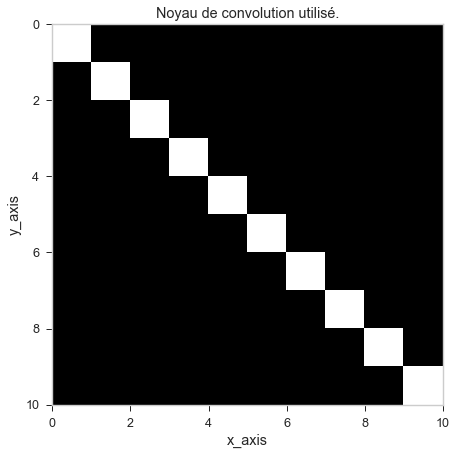

RANKS: 12, 16, 16


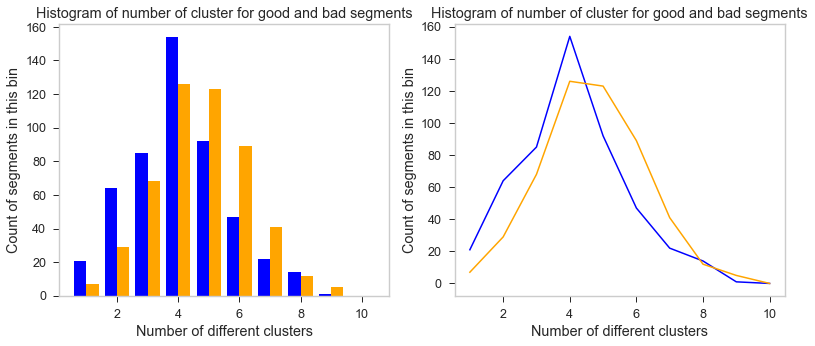

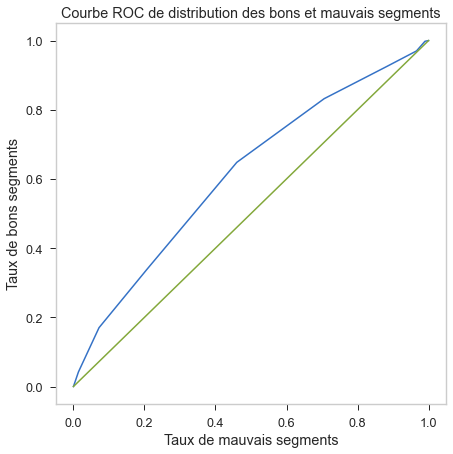

RANKS: 12, 16, 24


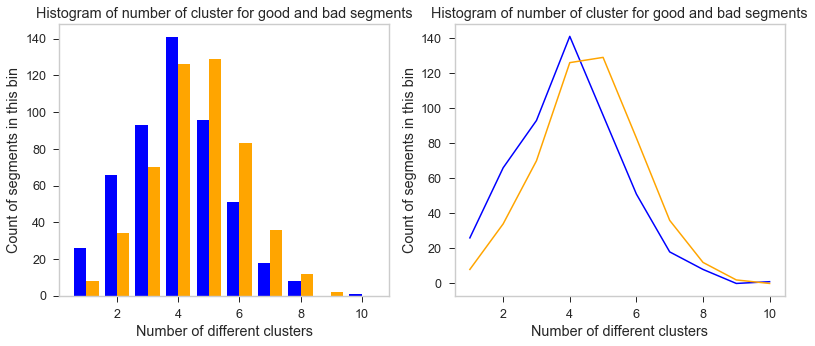

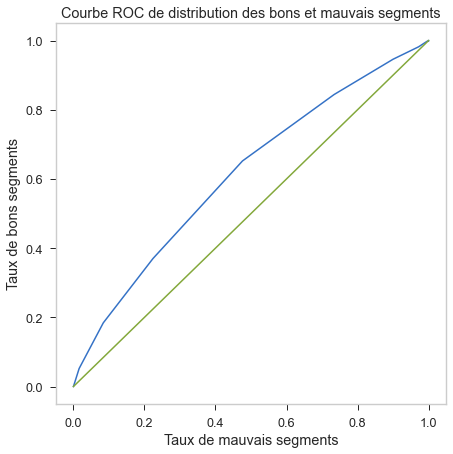

RANKS: 12, 16, 32


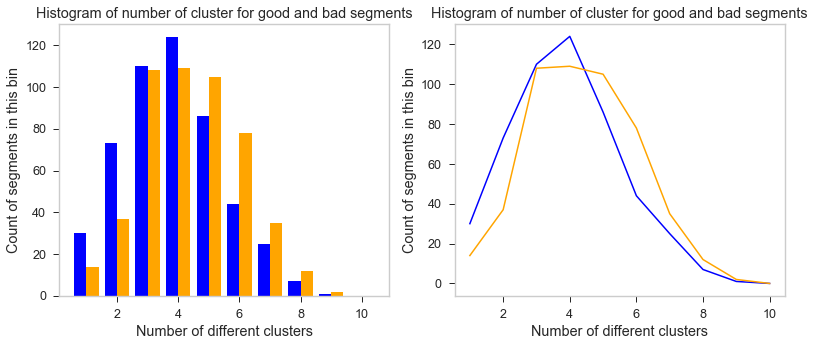

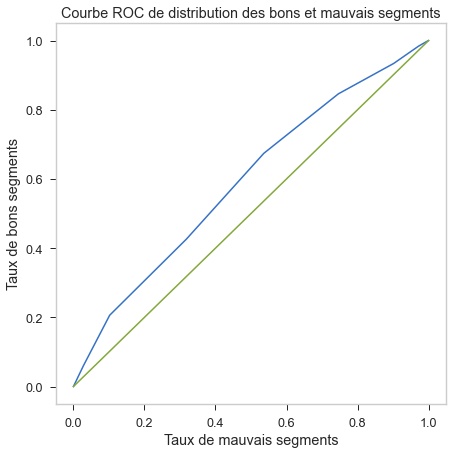

RANKS: 12, 24, 16


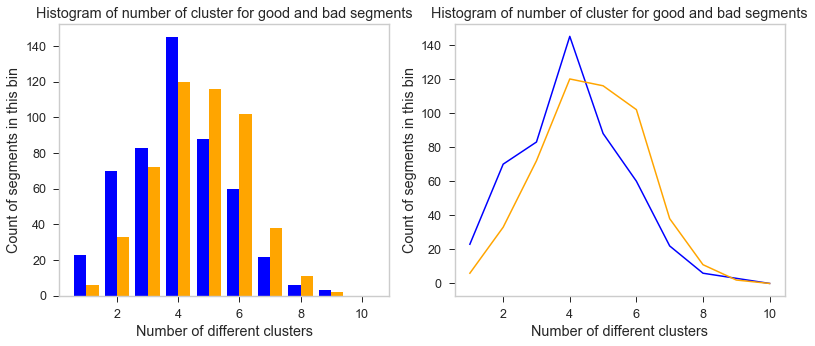

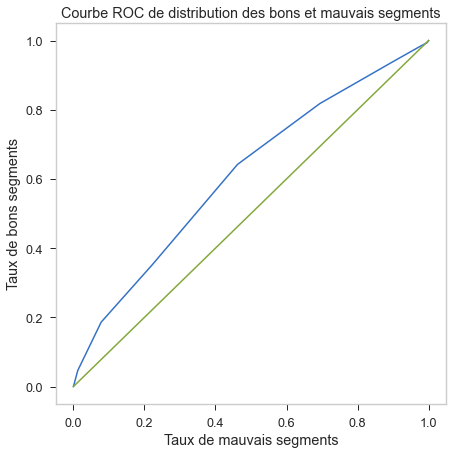

RANKS: 12, 24, 24


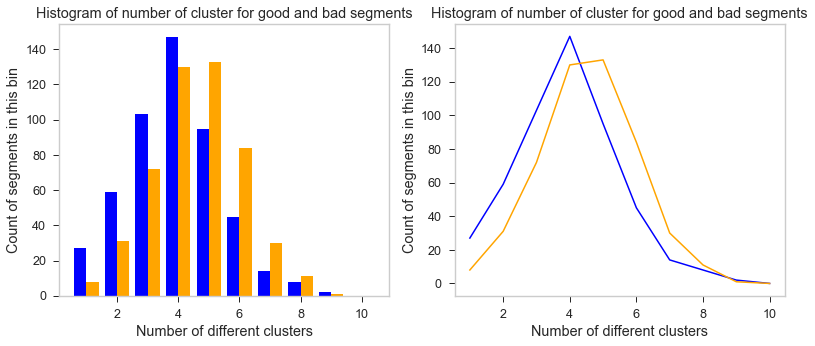

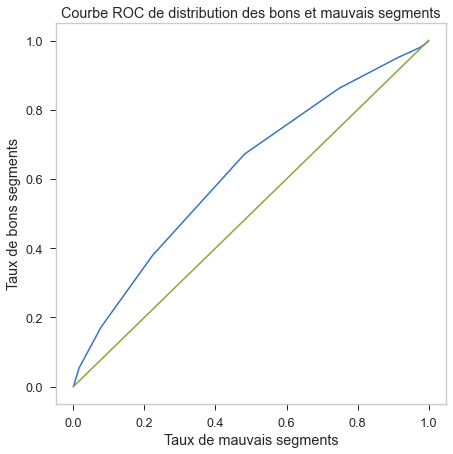

RANKS: 12, 24, 32


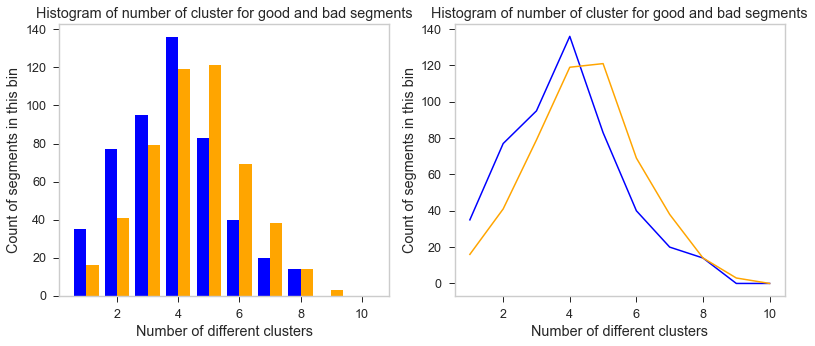

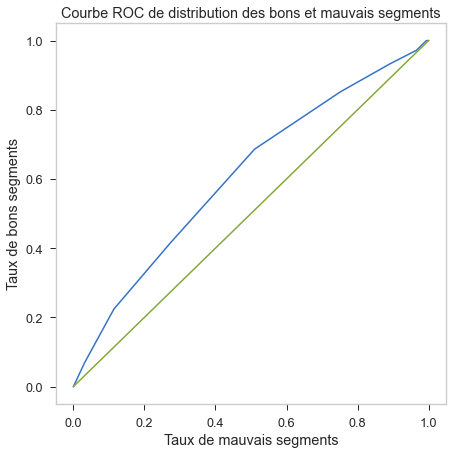

RANKS: 12, 32, 16


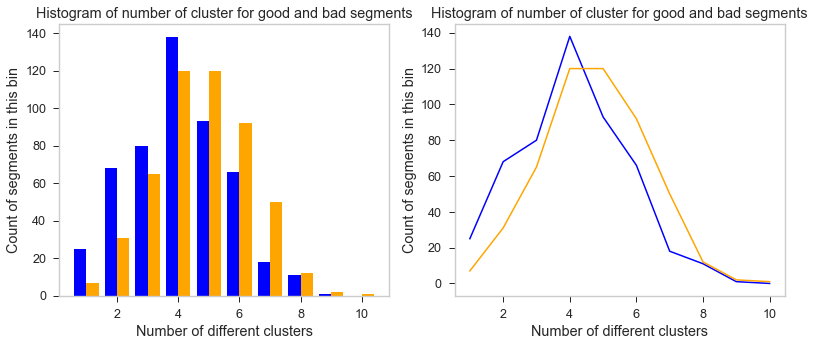

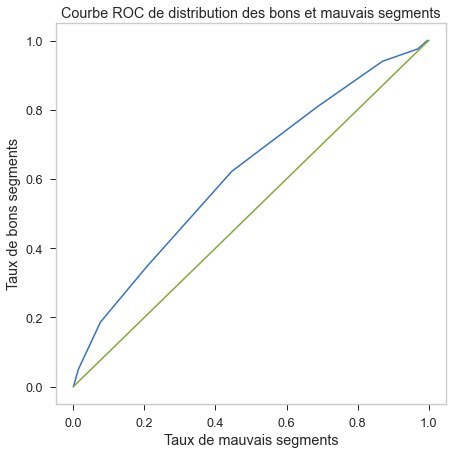

RANKS: 12, 32, 24


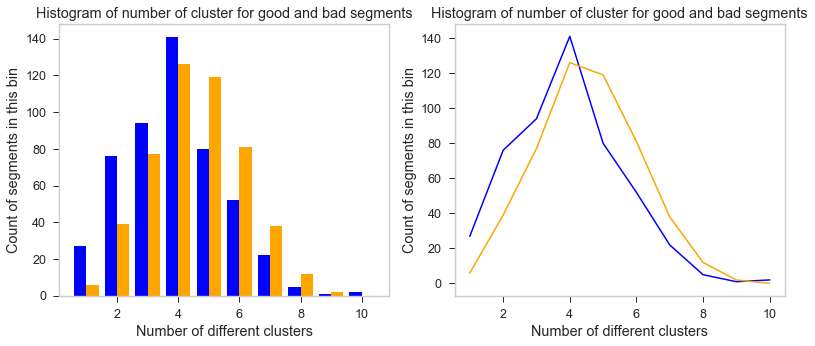

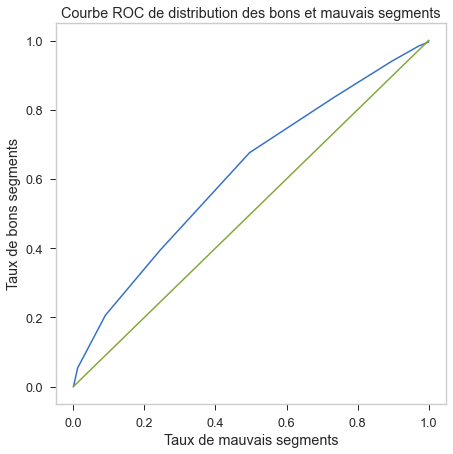

RANKS: 12, 32, 32


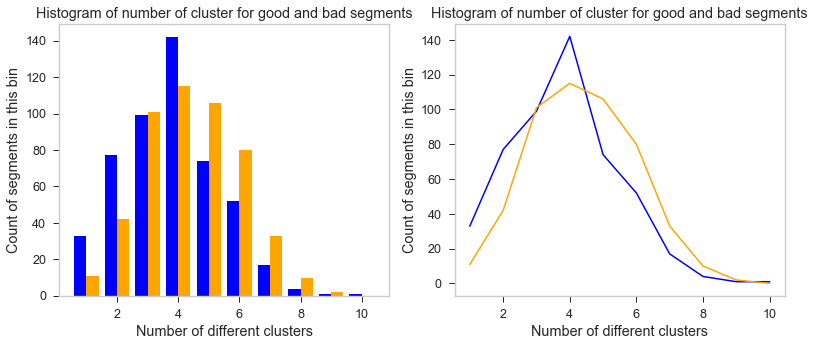

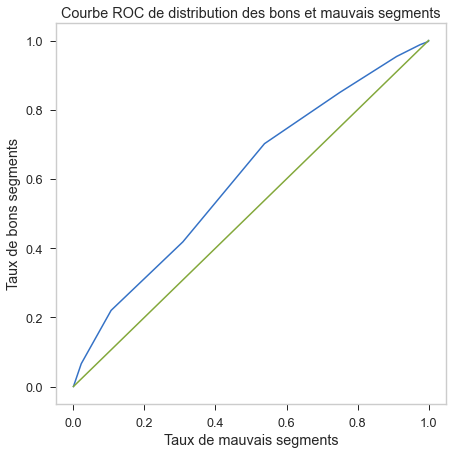

In [13]:
from sklearn.cluster import KMeans

#ranks = [12,32,32]
sampling_rate = 44100 # Obligatoire, sinon l'estimation des mesures ne fonctionne pas.
subdivision = 96
hop_length = 32
hop_length_seconds = hop_length/sampling_rate

kernels = as_seg.compute_all_kernels(32)
plot_me_this_spectrogram(kernels[10], title = "Noyau de convolution utilisé.")
ranks_of_h = [16,24,32]
ranks_of_q = [16,24,32]

for rank_h in ranks_of_h:
    for rank_q in ranks_of_q:
        f_mes_3 = []
        good_clus = []
        bad_clus = []
        ranks = [12,rank_h,rank_q]
        print("RANKS: 12, {}, {}".format(ranks[1], ranks[2]))
        for i, song_and_annotations in enumerate(paths):

            song_name = song_and_annotations[0].replace(".wav","")
            annot_path = "{}\\{}".format(annotations_folder, song_and_annotations[1])
            annotations = dm.get_segmentation_from_txt(annot_path, annotations_type)
            references_segments = np.array(annotations)[:, 0:2]

            bars, spectrogram = scr.load_or_save_spectrogram_and_bars(persisted_path, "{}\\{}".format(folder, song_name), "pcp", hop_length)

            annotations_frontiers_barwise = dm.frontiers_from_time_to_bar(references_segments[:,1], bars)
            annotations_segments_barwise = dm.frontiers_to_segments(annotations_frontiers_barwise)
   
            S = good_segments_all_songs[i]
            T = bad_segments_all_songs[i]
            
            tensor_spectrogram = tf.tensorize_barwise(spectrogram, bars, hop_length_seconds, subdivision)
            core, factors = scr.NTD_decomp_as_script(persisted_path, "_{}_{}_{}_{}".format(song_name, "pcp", "chromas", subdivision), tensor_spectrogram, ranks, init = "chromas")

            #autosimilarity = as_seg.get_autosimilarity(factors[2], transpose = True, normalize = True)
            kmeans = KMeans(n_clusters=10, random_state=0).fit(factors[2])
            
            #segments = as_seg.dynamic_convolution_computation(autosimilarity, convolution_type = "full", penalty_weight = 1, penalty_func = "modulo8")[0]
            #segments_in_time = dm.segments_from_bar_to_time(segments, bars)

            #f_mes_3.append(dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 3)[2])

            for good_segment in S:
                #print(np.unique(kmeans.labels_[good_segment[0]:good_segment[1]]))
                good_clus.append(len(np.unique(kmeans.labels_[good_segment[0]:good_segment[1]])))
            for bad_segment in T:
                bad_clus.append(len(np.unique(kmeans.labels_[bad_segment[0]:bad_segment[1]])))
        #plt.hist(f_mes_3, range = (0, 10), bins = 10)
        #plt.show()
        #print("F mesure moyenne: {}".format(np.mean(f_mes_3)))

        fig, axs = plt.subplots(1, 2, figsize=(13,5))
        axs[0].set_xlabel("Number of different clusters")
        axs[0].set_ylabel("Count of segments in this bin")
        n, bins, patches = axs[0].hist([good_clus, bad_clus], range = (0.5, 10.5), bins = 10, color = ['blue', 'orange'])
        axs[0].set_title("Histogram of number of cluster for good and bad segments")
        axs[1].set_xlabel("Number of different clusters")
        axs[1].set_ylabel("Count of segments in this bin")
        axs[1].plot([(bins[i] + bins[i+1])/2 for i in range(len(bins) - 1)], n[0], color = 'blue')
        axs[1].plot([(bins[i] + bins[i+1])/2 for i in range(len(bins) - 1)], n[1], color = 'orange')
        axs[1].set_title("Histogram of number of cluster for good and bad segments")
        plt.show()
        
        global_false = [0]
        global_good = [0]
        for i in range(n.shape[1]):
            global_false.append(global_false[-1] + n[1][i])
            global_good.append(global_good[-1] + n[0][i])
        plt.figure(figsize = (7,7))
        plt.plot(np.divide(global_false,len(bad_segments_all_songs)*number_of_segments), np.divide(global_good, len(good_segments_all_songs)*number_of_segments))
        plt.plot([0,1],[0,1])
        plt.ylabel("Taux de bons segments")
        plt.xlabel("Taux de mauvais segments")
        plt.title("Courbe ROC de distribution des bons et mauvais segments")
        plt.show()

# Tonnetz (with %4 size segments)

In [15]:
def compute_s_and_c_polytope(tensor):
    s_and_c = 0
    tensor_unfolded = tensor[:,:,0]
    for i in range(1,tensor.shape[2]):
        tensor_unfolded = np.append(tensor_unfolded, tensor[:,:,i], axis = 1)
    length = tensor_unfolded.shape[1]
    if length%16 != 0:
        raise NotImplementedError("Ah!")
    number_frame_per_summit = int(length / 16)
    # Low level systems
    for i in range(4):
        #x1 = np.mean(tensor_unfolded[:,4*i:4*i+number_frame_per_summit], axis=1)
        #x2 = np.mean(tensor_unfolded[:,4*i+number_frame_per_summit:4*i+2*number_frame_per_summit], axis=1)
        #x3 = np.mean(tensor_unfolded[:,4*i+2*number_frame_per_summit:4*i+3*number_frame_per_summit], axis=1)
        #x4 = np.mean(tensor_unfolded[:,4*i+3*number_frame_per_summit:4*(i+number_frame_per_summit)], axis=1)
        #s_and_c += compute_s_and_c(x1, x2, x3, x4)
        #s_and_c += compute_s_and_c(*[np.mean(tensor_unfolded[:,4*i+j*number_frame_per_summit:4*i+(j+1)*number_frame_per_summit], axis=1) for j in range (4)])
        s_and_c += compute_s_and_c(*[tensor_unfolded[:,4*i+j*number_frame_per_summit:4*i+(j+1)*number_frame_per_summit] for j in range (4)])

    # High level system
    s_and_c += compute_s_and_c(*[tensor_unfolded[:,4*i:4*i+number_frame_per_summit] for i in range(4)])
    return s_and_c
    
def compute_s_and_c(x1, x2, x3, x4):
    d1 = np.linalg.norm(x2 - x1, 2)
    d2 = np.linalg.norm(x3 - x1, 2)
    fictive_x4 = np.add(x3, np.subtract(x2, x1))
    d3 = np.linalg.norm(x4 - fictive_x4, 2)
    return d1 + d2 + d3

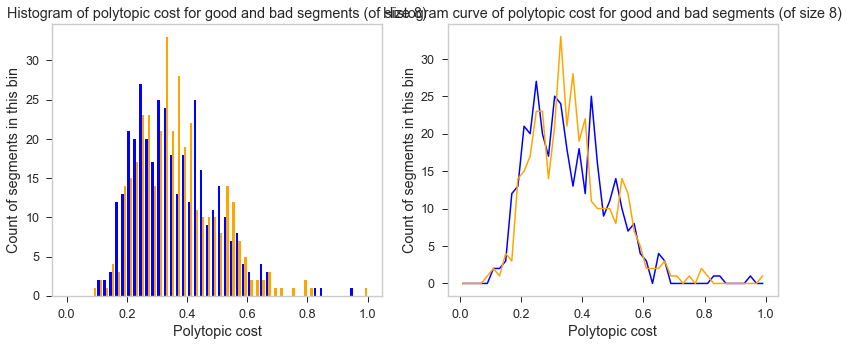

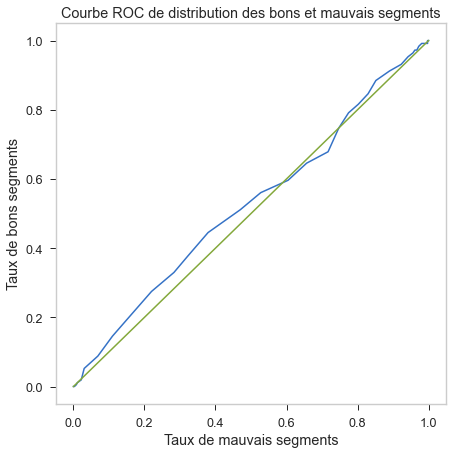

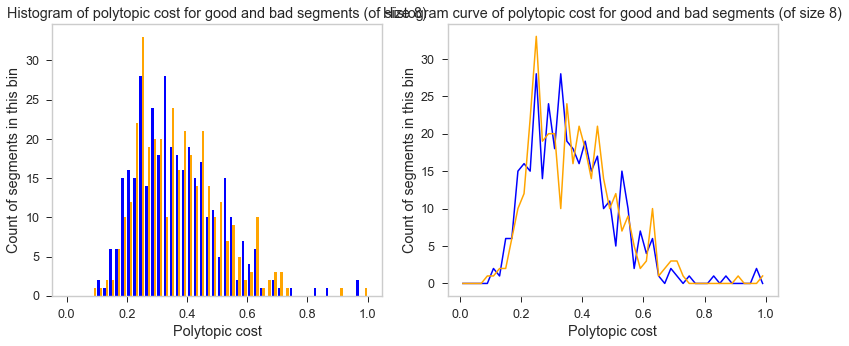

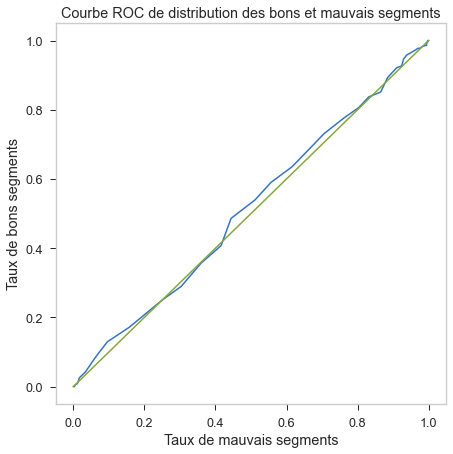

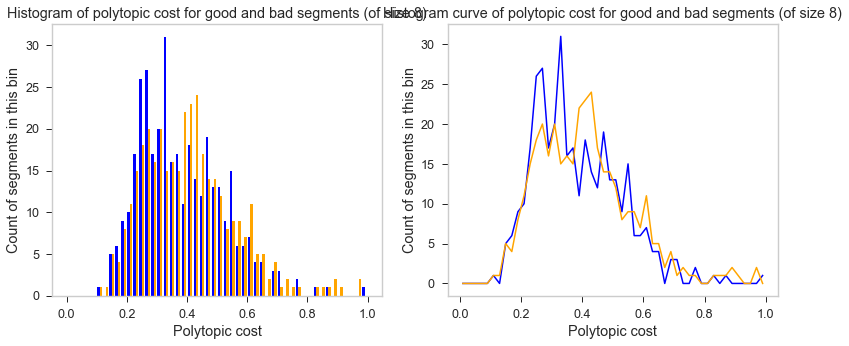

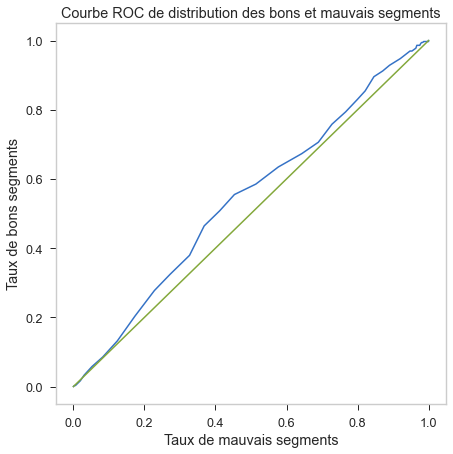

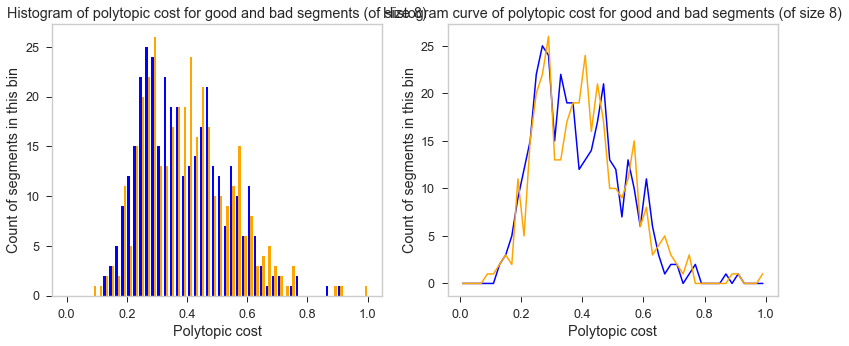

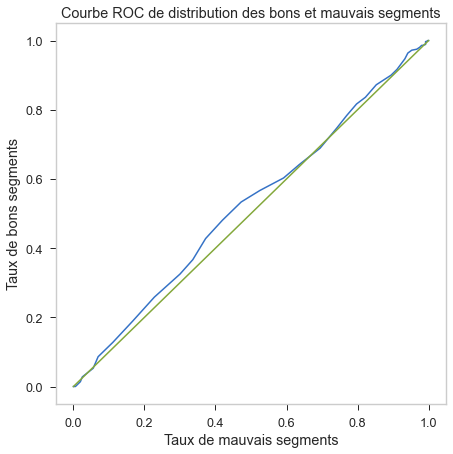

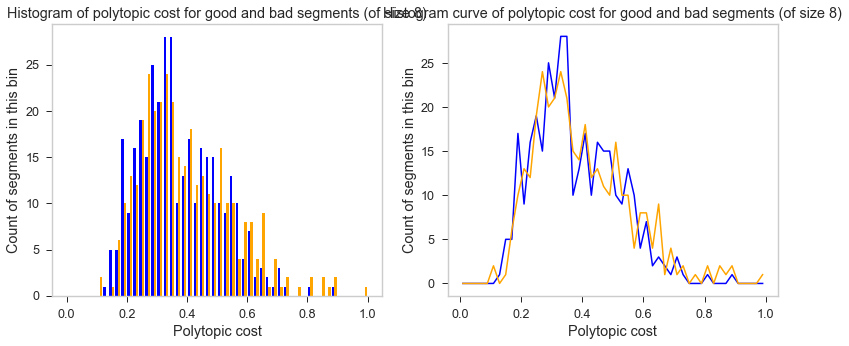

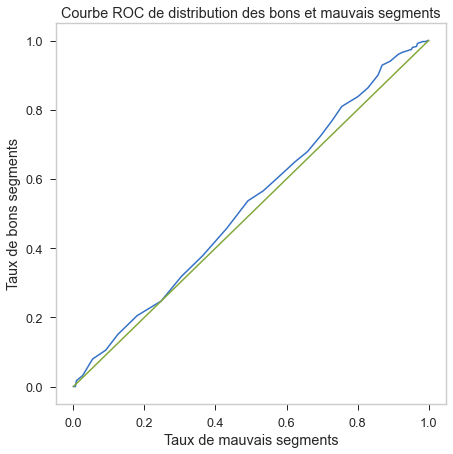

In [10]:
np.random.seed(42)
sampling_rate = 44100 # Obligatoire, sinon l'estimation des mesures ne fonctionne pas.
subdivision = 96
hop_length = 32
hop_length_seconds = hop_length/sampling_rate
for i in range(5):
    cnt_segments = 0

    number_of_segments = 4
    it_max = 300

    acceptable_lengths = [4,8]
    good_s_and_c = []
    bad_s_and_c = []
    for i, song_and_annotations in enumerate(paths):
        cnt = 0
        song_name = song_and_annotations[0].replace(".wav","")
        annot_path = "{}\\{}".format(annotations_folder, song_and_annotations[1])
        annotations = dm.get_segmentation_from_txt(annot_path, annotations_type)
        references_segments = np.array(annotations)[:, 0:2]

        bars = scr.load_or_save_bars(persisted_path, "{}\\{}".format(folder, song_name))

        annotations_frontiers_barwise = dm.frontiers_from_time_to_bar(references_segments[:,1], bars)
        annotations_segments_barwise = dm.frontiers_to_segments(annotations_frontiers_barwise)
        indexes = np.random.randint(1, high=len(annotations_segments_barwise) - 1, size = number_of_segments)
        while (any([annotations_segments_barwise[i][1] - annotations_segments_barwise[i][0] not in acceptable_lengths for i in indexes]) or len(np.unique(indexes)) != len(indexes)) and cnt <= it_max:
            indexes = np.random.randint(1, high=len(annotations_segments_barwise) - 1, size = number_of_segments)
            cnt += 1
        if all([annotations_segments_barwise[i][1] - annotations_segments_barwise[i][0] in acceptable_lengths for i in indexes]):
            cnt_segments += len(indexes)
            good_segments_for_tonnetz = [annotations_segments_barwise[i] for i in indexes]

            bad_segments_for_tonnetz = []
            for i in indexes:
                seg_size = annotations_segments_barwise[i][1] - annotations_segments_barwise[i][0]
                lag = np.random.randint(1, high=seg_size)
                if annotations_segments_barwise[i][1] + lag >= annotations_segments_barwise[-1][1]:
                    bad_segments_for_tonnetz.append((annotations_segments_barwise[i][0] - lag,annotations_segments_barwise[i][1] - lag))
                else:
                    bad_segments_for_tonnetz.append((annotations_segments_barwise[i][0] + lag,annotations_segments_barwise[i][1] + lag))

            tonnetz = scr.load_or_save_spectrogram(persisted_path, "{}\\{}".format(folder, "{}.wav".format(song_name)), "pcp_tonnetz", hop_length)
            tensor_tonnetz = tf.tensorize_barwise(tonnetz, bars, hop_length_seconds, subdivision)
            
            for good_segment in good_segments_for_tonnetz:
                good_s_and_c.append(compute_s_and_c_polytope(tensor_tonnetz[:,:,good_segment[0]:good_segment[1]]))
            for bad_segment in bad_segments_for_tonnetz:
                bad_s_and_c.append(compute_s_and_c_polytope(tensor_tonnetz[:,:,bad_segment[0]:bad_segment[1]]))
    
    highest_val = max(np.amax(good_s_and_c), np.amax(bad_s_and_c))
    good_s_and_c = good_s_and_c/highest_val
    bad_s_and_c = bad_s_and_c/highest_val

    fig, axs = plt.subplots(1, 2, figsize=(13,5))
    axs[0].set_xlabel("Polytopic cost")
    axs[0].set_ylabel("Count of segments in this bin")
    n, bins, patches = axs[0].hist([good_s_and_c, bad_s_and_c], range = (0, 1), bins = 50, color = ['blue', 'orange'])
    axs[0].set_title("Histogram of polytopic cost for good and bad segments (of size 8)")
    axs[1].set_xlabel("Polytopic cost")
    axs[1].set_ylabel("Count of segments in this bin")
    axs[1].plot([(bins[i] + bins[i+1])/2 for i in range(len(bins) - 1)], n[0], color = 'blue')
    axs[1].plot([(bins[i] + bins[i+1])/2 for i in range(len(bins) - 1)], n[1], color = 'orange')
    axs[1].set_title("Histogram curve of polytopic cost for good and bad segments (of size 8)")
    plt.show()

    global_false = [0]
    global_good = [0]
    for i in range(n.shape[1]):
        global_false.append(global_false[-1] + n[1][i])
        global_good.append(global_good[-1] + n[0][i])
    plt.figure(figsize = (7,7))
    plt.plot(np.divide(global_false,cnt_segments), np.divide(global_good, cnt_segments))
    plt.plot([0,1],[0,1])
    plt.ylabel("Taux de bons segments")
    plt.xlabel("Taux de mauvais segments")
    plt.title("Courbe ROC de distribution des bons et mauvais segments")
    plt.show()